## Testing GravNet on a toy model example

Toy model where GravNet is classifying gaussian blobs in 2D space

### What the Toy GravNet Script Does

The script generates synthetic “calorimeter-like” events consisting of 2D Gaussian blobs (clusters) plus noise, where each point (hit) has features `(x, y, energy)` and a ground-truth cluster label. The synthetic data illustrates a single ECal layer

These hits are treated as nodes in a graph. The `GravNetConv` layers dynamically construct a k-nearest-neighbor graph in a learned latent space and perform message passing between neighboring nodes. This allows each hit to aggregate information from nearby hits.

The model is trained as a node-classification task: for each hit, it predicts which cluster it belongs to (or noise). During training, cross-entropy loss is minimized between predicted labels and true cluster IDs.

In summary, the script implements a Graph Neural Network (GNN) that learns to cluster spatially distributed hits by dynamically building graphs and propagating information between neighbors.


In [59]:
# Cell 2 — imports + extended sanity check
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GravNetConv

print("torch:", torch.__version__)
print("torch cuda version:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Verify GravNet layer instantiates
layer = GravNetConv(
    in_channels=3,
    out_channels=32,
    space_dimensions=2,
    propagate_dimensions=16,
    k=16
)

print("GravNetConv OK")


torch: 2.8.0+cpu
torch cuda version: None
cuda available: False
device count: 0
GravNetConv OK


### Generating synthetic data - Gaussian blobs in 3D space

In [60]:
NUM_CLASSES = 5
NOISE_LABEL = 4

def center_to_quadrant_class(cx, cy):
    if cx >= 0 and cy >= 0:
        return 0
    if cx < 0 and cy >= 0:
        return 1
    if cx < 0 and cy < 0:
        return 2
    return 3

def make_blob_event(
    n_points=400,
    n_clusters_range=(2, 4),      # can vary clusters; labels remain consistent by quadrant
    noise_frac=0.10,
    sigma_range=(0.15, 0.45),
    center_range=(-4.0, 4.0),
    energy_range=(0.5, 2.0),
    seed=None,
):
    rng = np.random.default_rng(seed)

    n_clusters = int(rng.integers(n_clusters_range[0], n_clusters_range[1] + 1))
    n_noise = int(round(n_points * noise_frac))
    n_signal = n_points - n_noise

    # Split signal points among clusters
    counts = rng.multinomial(n_signal, np.ones(n_clusters) / n_clusters)

    xs = []
    ys = []

    # Sample centers
    centers = rng.uniform(center_range[0], center_range[1], size=(n_clusters, 2))
    sigmas = rng.uniform(sigma_range[0], sigma_range[1], size=(n_clusters,))

    # Generate blobs with semantic (quadrant) class labels
    for i in range(n_clusters):
        cx, cy = centers[i]
        s = sigmas[i]
        cls = center_to_quadrant_class(cx, cy)

        pts = rng.normal(loc=(cx, cy), scale=s, size=(counts[i], 2)).astype(np.float32)

        # "energy" feature: correlated with radius to make it non-trivial but learnable
        r = np.sqrt((pts[:, 0] - cx) ** 2 + (pts[:, 1] - cy) ** 2)
        e = (rng.uniform(energy_range[0], energy_range[1], size=(counts[i],)) * np.exp(-0.5 * (r / (s + 1e-6)) ** 2)).astype(np.float32)

        feat = np.column_stack([pts, e]).astype(np.float32)
        xs.append(feat)
        ys.append(np.full((counts[i],), cls, dtype=np.int64))

    # Generate noise with fixed label
    noise_xy = rng.uniform(center_range[0], center_range[1], size=(n_noise, 2)).astype(np.float32)
    noise_e = rng.uniform(energy_range[0], energy_range[1], size=(n_noise,)).astype(np.float32) * 0.5
    noise_x = np.column_stack([noise_xy, noise_e]).astype(np.float32)
    noise_y = np.full((n_noise,), NOISE_LABEL, dtype=np.int64)

    xs.append(noise_x)
    ys.append(noise_y)

    x = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)

    # Shuffle
    perm = rng.permutation(x.shape[0])
    x = x[perm]
    y = y[perm]

    return Data(x=torch.from_numpy(x), y=torch.from_numpy(y))

### Build training and validation datasets 

In [61]:
# Cell 4 — build train/val datasets
def make_dataset(n_events, seed=12345, **kwargs):
    rng = np.random.default_rng(seed)
    data_list = []
    for i in range(n_events):
        data_list.append(make_blob_event(seed=int(rng.integers(0, 2**31 - 1)), **kwargs))
    return data_list

def compute_feature_norm_stats(data_list):
    # compute mean/std over all nodes in dataset
    xs = torch.cat([d.x for d in data_list], dim=0).float()
    mean = xs.mean(dim=0)
    std = xs.std(dim=0).clamp_min(1e-6)
    return mean, std

def apply_feature_norm(data_list, mean, std):
    for d in data_list:
        d.x = (d.x.float() - mean) / std
    return data_list

# Create train/val
train_data = make_dataset(
    n_events=2000,
    seed=1,
    n_points=400,
    n_clusters_range=(2, 4),
    noise_frac=0.15,
    sigma_range=(0.18, 0.55),
    center_range=(-4.0, 4.0),
)

val_data = make_dataset(
    n_events=400,
    seed=2,
    n_points=400,
    n_clusters_range=(2, 4),
    noise_frac=0.15,
    sigma_range=(0.18, 0.55),
    center_range=(-4.0, 4.0),
)

mean, std = compute_feature_norm_stats(train_data)
train_data = apply_feature_norm(train_data, mean, std)
val_data = apply_feature_norm(val_data, mean, std)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=0)




### Define model: 2x GravNet + MLP head classifier

In [62]:
# Cell 5 — model: 2x GravNet + MLP head (node classification)
class GravNetToy(nn.Module):
    def __init__(self, in_dim=3, hidden=64, space_dim=2, prop_dim=32, k=12, num_classes=NUM_CLASSES, dropout=0.0):
        super().__init__()
        self.gn1 = GravNetConv(in_dim, hidden, space_dimensions=space_dim, propagate_dimensions=prop_dim, k=k)
        self.gn2 = GravNetConv(hidden, hidden, space_dimensions=space_dim, propagate_dimensions=prop_dim, k=k)

        self.bn1 = nn.BatchNorm1d(hidden)
        self.bn2 = nn.BatchNorm1d(hidden)

        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes),
        )

    def forward(self, data):
        x = data.x
        batch = data.batch  # require batch

        x = self.gn1(x, batch)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.gn2(x, batch)
        x = self.bn2(x)
        x = F.relu(x)

        return self.head(x)

# -------------------------
# 4) Loss (handles imbalance)
# -------------------------
def compute_class_weights(data_list, num_classes=NUM_CLASSES):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for d in data_list:
        counts += torch.bincount(d.y, minlength=num_classes)
    counts = counts.float()
    # inverse-frequency weights; normalize to mean 1
    w = counts.sum() / (counts + 1e-6)
    w = w / w.mean()
    return w, counts

class_weights, train_counts = compute_class_weights(train_data, NUM_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GravNetToy(in_dim=3, hidden=64, space_dim=2, prop_dim=32, k=12, num_classes=NUM_CLASSES, dropout=0.0).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode="min",
    factor=0.5,
    patience=5
)


# -------------------------
# 5) Metrics
# -------------------------
@torch.no_grad()
def confusion_matrix(pred, target, num_classes=NUM_CLASSES):
    cm = torch.zeros((num_classes, num_classes), dtype=torch.long, device=pred.device)
    for t, p in zip(target.view(-1), pred.view(-1)):
        cm[t, p] += 1
    return cm

@torch.no_grad()
def per_class_recall(cm):
    # recall_i = TP_i / (TP_i + FN_i)
    tp = cm.diag().float()
    denom = cm.sum(dim=1).float().clamp_min(1)
    return (tp / denom).cpu()

@torch.no_grad()
def per_class_precision(cm):
    tp = cm.diag().float()
    denom = cm.sum(dim=0).float().clamp_min(1)
    return (tp / denom).cpu()


### Training/Eval helper functions

In [63]:
def train_one_epoch(model, loader, opt, class_weights=None):
    model.train()
    total_loss = 0.0
    n_nodes = 0

    for data in loader:
        data = data.to(device)
        assert hasattr(data, "batch") and data.batch is not None

        opt.zero_grad(set_to_none=True)
        logits = model(data)
        y = data.y

        if class_weights is not None:
            loss = F.cross_entropy(logits, y, weight=class_weights.to(device))
        else:
            loss = F.cross_entropy(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()

        total_loss += loss.item() * y.numel()
        n_nodes += y.numel()

    return total_loss / max(1, n_nodes)

@torch.no_grad()
def evaluate(model, loader, class_weights=None):
    model.eval()
    total_loss = 0.0
    n_nodes = 0
    correct = 0
    cm_total = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.long, device=device)

    for data in loader:
        data = data.to(device)
        logits = model(data)
        y = data.y

        if class_weights is not None:
            loss = F.cross_entropy(logits, y, weight=class_weights.to(device))
        else:
            loss = F.cross_entropy(logits, y)

        pred = logits.argmax(dim=-1)
        correct += (pred == y).sum().item()

        cm_total += confusion_matrix(pred, y, NUM_CLASSES)

        total_loss += loss.item() * y.numel()
        n_nodes += y.numel()

    val_loss = total_loss / max(1, n_nodes)
    val_acc = correct / max(1, n_nodes)

    recall = per_class_recall(cm_total)
    precision = per_class_precision(cm_total)

    return val_loss, val_acc, cm_total.detach().cpu(), recall, precision



### Run training

In [ ]:
# -------------------------
# 7) Run training
# -------------------------
print("Train class counts:", train_counts.tolist())
print("Class weights:", class_weights.tolist())

best_val = float("inf")
best_state = None

EPOCHS = 30
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, opt, class_weights=class_weights)
    va_loss, va_acc, cm, rec, prec = evaluate(model, val_loader, class_weights=class_weights)

    scheduler.step(va_loss)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch == 1 or epoch % 5 == 0:
        print(
            f"epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_acc {va_acc:.4f}"
        )
        print("  recall   :", [round(x, 3) for x in rec.tolist()])
        print("  precision:", [round(x, 3) for x in prec.tolist()])

# Restore best
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

va_loss, va_acc, cm, rec, prec = evaluate(model, val_loader, class_weights=class_weights)
print(f"\nBEST | val_loss {va_loss:.4f} | val_acc {va_acc:.4f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm.numpy())
print("Recall   :", rec.tolist())
print("Precision:", prec.tolist())


Train class counts: [161487.0, 177281.0, 167094.0, 174138.0, 120000.0]
Class weights: [0.9707927703857422, 0.8843047022819519, 0.9382169842720032, 0.9002653956413269, 1.306420087814331]


epoch 01 | train_loss 0.5764 | val_loss 0.3109 | val_acc 0.9075
  recall   : [0.887, 0.935, 0.937, 0.939, 0.808]
  precision: [0.935, 0.907, 0.893, 0.884, 0.934]
epoch 05 | train_loss 0.2555 | val_loss 0.1930 | val_acc 0.9393
  recall   : [0.963, 0.928, 0.946, 0.939, 0.916]
  precision: [0.911, 0.95, 0.931, 0.938, 0.981]


### Plot

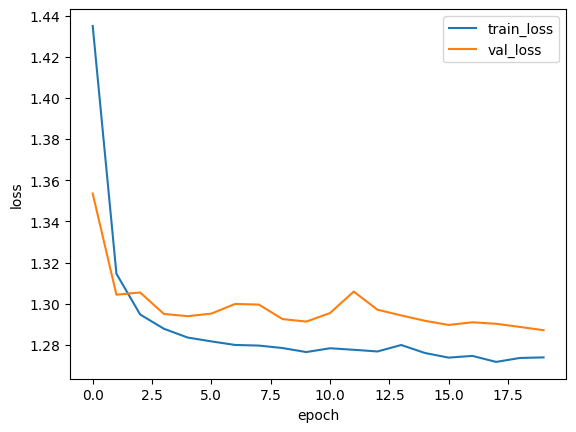

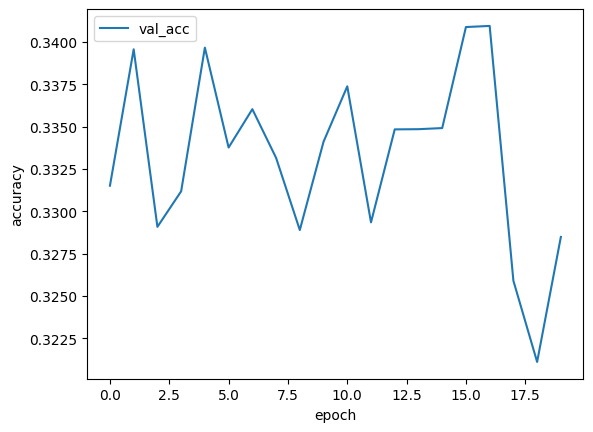

In [ ]:
# Cell 8 — plot curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


### Visualisation

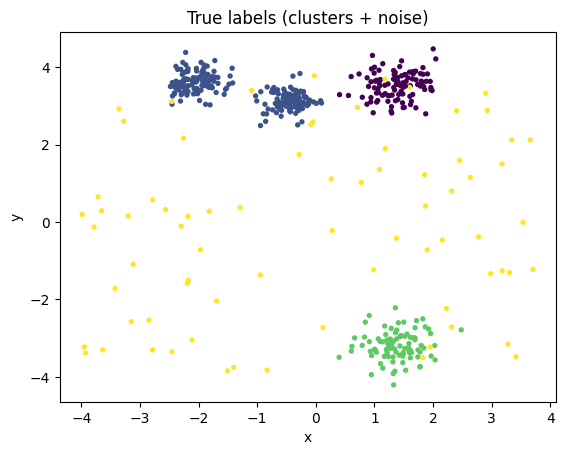

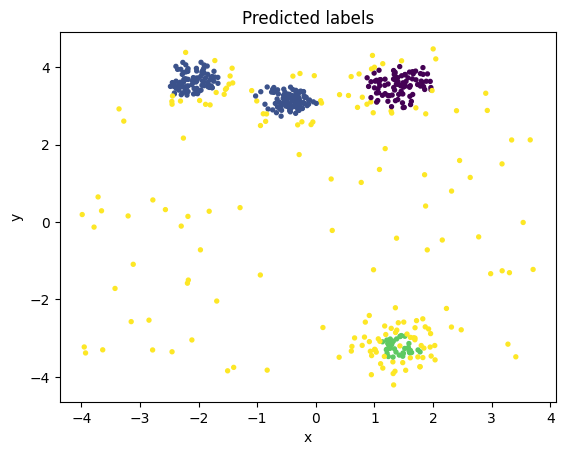

In [ ]:
# Cell 9 — visualize one event: true vs predicted labels (2D scatter)
@torch.no_grad()
def predict_event(data):
    model.eval()
    data = data.to(device)
    logits = model(data)
    pred = logits.argmax(dim=-1).cpu()
    return pred

# pick a fresh event with a fixed seed for repeatability
sample = make_blob_event(
    n_points=500,
    n_clusters_range=(4, 4),
    noise_frac=0.15,
    seed=12345,
)
pred = predict_event(sample)

xy = sample.x[:, :2].numpy()
y_true = sample.y.numpy()
y_pred = pred.numpy()

def scatter_labels(xy, labels, title):
    plt.figure()
    plt.scatter(xy[:, 0], xy[:, 1], s=8, c=labels)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

scatter_labels(xy, y_true, "True labels (clusters + noise)")
scatter_labels(xy, y_pred, "Predicted labels")


### Extra: make it more reconstruction-like

In [ ]:
# Cell 10 — (optional) make it more "reco-like": ignore noise label in the loss
# This is often useful if you want the model to focus on assigning shower hits and treat noise separately.

IGNORE_NOISE = True
noise_label = NUM_CLASSES - 1  # by construction we used last class as noise

def train_one_epoch_masked(loader):
    model.train()
    total = 0
    total_loss = 0.0

    for data in loader:
        data = data.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(data)

        if IGNORE_NOISE:
            mask = (data.y != noise_label)
            loss = F.cross_entropy(logits[mask], data.y[mask], reduction="mean")
            n = int(mask.sum().item())
        else:
            loss = F.cross_entropy(logits, data.y, reduction="mean")
            n = data.y.numel()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        total += n
        total_loss += loss.item() * n

    return total_loss / max(total, 1)

# Example: fine-tune 5 epochs with masked loss
for epoch in range(1, 6):
    tr_loss = train_one_epoch_masked(train_loader)
    va_loss, va_acc = evaluate(val_loader)
    print(f"[masked] epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_acc {va_acc:.4f}")


[masked] epoch 01 | train_loss 1.2387 | val_loss 1.4504 | val_acc 0.3295
[masked] epoch 02 | train_loss 1.2249 | val_loss 1.5149 | val_acc 0.3369
[masked] epoch 03 | train_loss 1.2261 | val_loss 1.5402 | val_acc 0.3279
[masked] epoch 04 | train_loss 1.2210 | val_loss 1.5422 | val_acc 0.3321
[masked] epoch 05 | train_loss 1.2216 | val_loss 1.5710 | val_acc 0.3255
